# Решение домашнего задания #2

In [76]:
import matplotlib.pyplot as plt

import numpy as np

from tqdm import tqdm

import torch
import torchmetrics as tm

torch.set_float32_matmul_precision('medium')

from torchvision.transforms import v2, functional as F

from lightning.pytorch import LightningDataModule, LightningModule, Trainer # To speed up training
from lightning.pytorch.loggers import TensorBoardLogger

import kagglehub
import datasets # Why huggingface datasets if we using kagglehub dataset?!

In [2]:
dataset_path = kagglehub.dataset_download("hlrhegemony/pokemon-image-dataset")
dataset = datasets.load_dataset(dataset_path, split="train") # With two lines of code we have a datasets.Dataset with all data loaded =]

Resolving data files:   0%|          | 0/2503 [00:00<?, ?it/s]

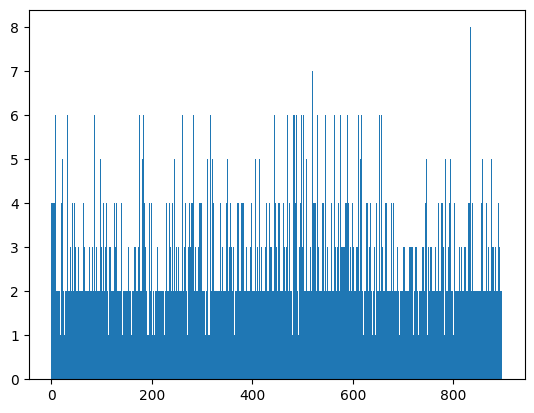

In [3]:
entry_count = len(dataset)
poke_count = len(np.unique(dataset["label"]))

plt.hist(dataset["label"], bins=poke_count)
plt.show()

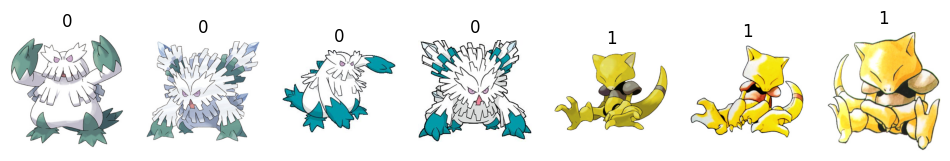

In [ ]:
def show_images(images, labels):
    fig, axes = plt.subplots(1, len(images), figsize=(12, 12))
    for i, (image, label) in enumerate(zip(images, labels)):
        axes[i].imshow(image)
        axes[i].set_title(label)
        axes[i].axis("off")
    plt.show()

show_images(dataset["image"][:7], dataset["label"][:7])

Заметим, что делить на тест-траин такую выборку - бессмысленно, т.к. технически изображения очень разные для одного и того же существа. В таком случае лучше в качестве траина взять аугментацию, а в качестве теста - весь датасет.

In [33]:
class AugmentationalDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform, expand_aspect=5):
        self.dataset = dataset
        self.transform = transform
        self.expand_aspect = expand_aspect

    def __len__(self):
        return len(self.dataset) * self.expand_aspect
    
    def __getitem__(self, idx):
        idx = idx % len(self.dataset)
        image = self.dataset[idx]["image"]
        label = self.dataset[idx]["label"]
        return self.transform(image), label
    
transform_aug = v2.Compose([
    v2.ToTensor(),
    v2.RandomHorizontalFlip(),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    v2.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    v2.RandomPerspective(distortion_scale=0.5, p=0.5),
    v2.RandomResizedCrop(224, scale=(0.8, 1.0)),
    v2.Resize((128, 128)),
    v2.Normalize((0.5,), (0.5,))
])

transform_val = v2.Compose([
    v2.ToTensor(),
    v2.Resize((128, 128)),
    v2.Normalize((0.5,), (0.5,))
])

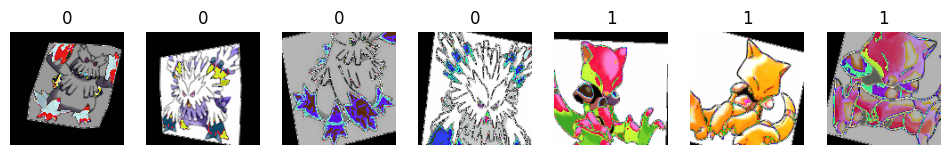

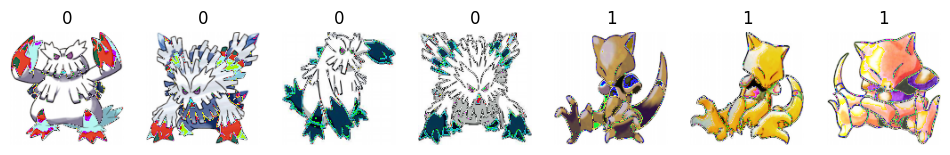

In [35]:
show_images([F.to_pil_image(transform_aug(image)) for image in dataset["image"][:7]], dataset["label"][:7])
show_images([F.to_pil_image(transform_val(image)) for image in dataset["image"][:7]], dataset["label"][:7])

В целом, изображения весьма сильно отличаются от исходеных, так что можно сказать, что тестовая часть не попала в траин.

In [36]:
class PokeClassifier(LightningModule):
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear(128 * 16 * 16, poke_count),
        )
        self.loss = torch.nn.CrossEntropyLoss()
        self.acc = tm.Accuracy(task="multiclass", num_classes=poke_count)

        self.train_acc = []
        self.val_acc = []
        self.train_loss = []
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        acc = self.acc(logits, y)
        self.log("train/acc", acc, prog_bar=True)
        self.log("train/loss", loss, prog_bar=True)
        self.train_acc.append(acc)
        self.train_loss.append(loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        pred = torch.argmax(logits, dim=1)
        acc = self.acc(pred, y)
        self.log("val/acc", acc, prog_bar=True)
        self.val_acc.append(acc)
        return acc
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)
    
class PokeDataModule(LightningDataModule):
    def __init__(self, dataset, batch_size):
        super().__init__()
        self.dataset = dataset
        self.batch_size = batch_size
        
    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            AugmentationalDataset(self.dataset, transform_aug),
            batch_size=self.batch_size,
            shuffle=True,
            # num_workers=15,
            # persistent_workers=True,
        )
    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            AugmentationalDataset(self.dataset, transform_val, 1),
            batch_size=self.batch_size,
            # num_workers=15,
            # persistent_workers=True,
        )
    

model = PokeClassifier()
dm = PokeDataModule(dataset, 64)

In [38]:
logger = TensorBoardLogger("tb_logs", name="my_model")
trainer = Trainer(max_epochs=5, accelerator="auto", profiler="simple", logger=logger, log_every_n_steps=5)
trainer.fit(model, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type               | Params | Mode 
-----------------------------------------------------
0 | model | Sequential         | 29.5 M | train
1 | loss  | CrossEntropyLoss   | 0      | train
2 | acc   | MulticlassAccuracy | 0      | train
-----------------------------------------------------
29.5 M    Trainable params
0         Non-trainable params
29.5 M    Total params
118.079   Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
FIT Profiler Report

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                 

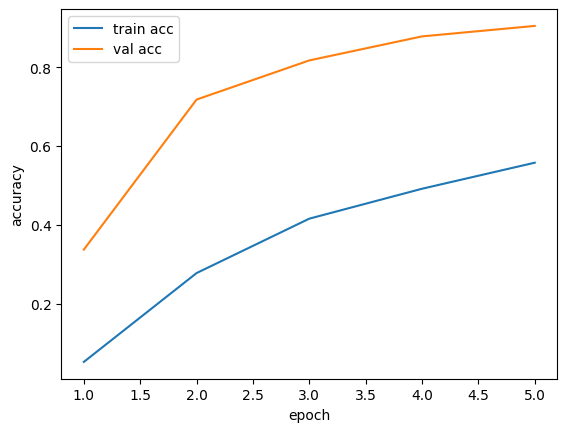

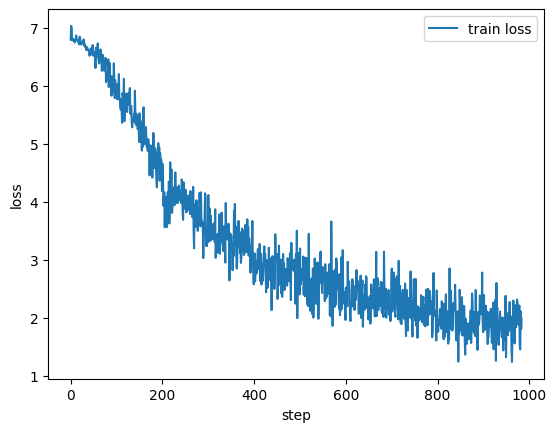

In [67]:
train_acc = torch.tensor(model.train_acc).cpu()
val_acc = torch.tensor(model.val_acc).cpu()
train_loss = torch.tensor(model.train_loss).cpu()

# Chunk acc to epochs
train_acc = train_acc[4:].reshape(-1, len(dm.train_dataloader()), 1).mean(1).flatten()
val_acc = val_acc[4:].reshape(-1, len(dm.val_dataloader()), 1).mean(1).flatten()

plt.plot(np.arange(1, 6), train_acc, label="train acc")
plt.plot(np.arange(1, 6), val_acc, label="val acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

plt.plot(train_loss, label="train loss")
plt.xlabel("step")
plt.ylabel("loss")
plt.legend()
plt.show()

In [77]:
def calculate_accuracy(model, dataset, transform):
    model.eval()
    
    acc = 0
    for entry in tqdm(dataset):
        image, label = entry["image"], entry["label"]
        image = transform(image).unsqueeze(0)
        pred = torch.argmax(model(image), dim=1)
        acc += (pred == label).item()
    return acc / len(dataset)

train_acc = calculate_accuracy(model, dataset, transform_aug)
test_acc = calculate_accuracy(model, dataset, transform_val)

print(f"Train accuracy: {train_acc:.2f}")
print(f"Test accuracy: {test_acc:.2f}")

100%|██████████| 2503/2503 [00:16<00:00, 149.67it/s]

Train accuracy: 0.58
Test accuracy: 0.91


В целом, мы хорошо научились предсказывать наших покемонов, хотя на трейне у нас довольно слабый скор (т.к. там все время новые данные и для обобщения нужно больше эпох)

100%|██████████| 2503/2503 [00:13<00:00, 190.31it/s]


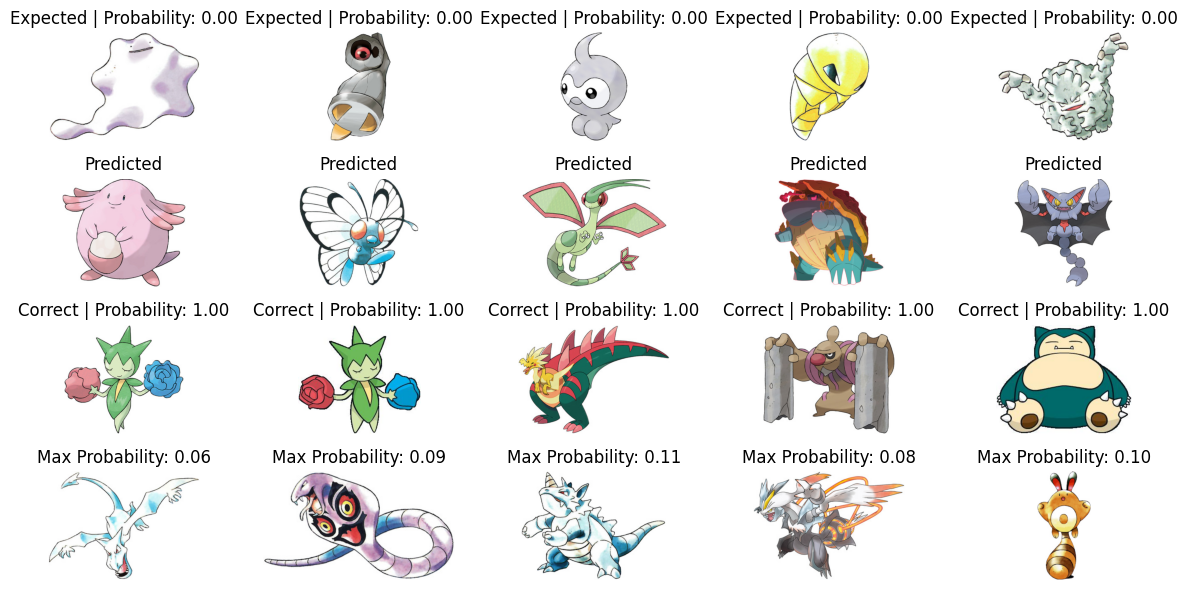

In [88]:
# visualise most accurate predictions
def show_most_and_less_accurate(model, dataset, transform, n=5):
    model.eval()
    
    predicted_probs = []
    max_probs = []

    predictions = []
    
    for image, label in tqdm(zip(dataset["image"], dataset["label"]), total=len(dataset)):
        image = transform(image).unsqueeze(0)
        pred = model(image)

        probs = torch.softmax(pred, dim=1).squeeze(0)
        proba = probs[label].item()
        max_prob = probs.max().item()

        predictions.append(pred.argmax().item())
        predicted_probs.append(proba)
        max_probs.append(max_prob)

    sorted_indices = np.argsort(predicted_probs)
    sorted_max_probs = np.argsort(max_probs)

    most_accurate_indices = sorted_indices[:n]
    least_accurate_indices = sorted_indices[-n:]

    least_ensure_indices = sorted_max_probs[:n]

    fig, axes = plt.subplots(4, n, figsize=(12, 6))
    for i, idx in enumerate(most_accurate_indices):
        axes[0, i].imshow(dataset["image"][idx])
        axes[0, i].set_title(f"Expected | Probability: {predicted_probs[idx]:.2f}")
        axes[0, i].axis("off")

        axes[1, i].imshow(dataset["image"][predictions[idx]])
        axes[1, i].set_title(f"Predicted")
        axes[1, i].axis("off")

    for i, idx in enumerate(least_accurate_indices):
        axes[2, i].imshow(dataset["image"][idx])
        axes[2, i].set_title(f"Correct | Probability: {predicted_probs[idx]:.2f}")
        axes[2, i].axis("off")

    for i, idx in enumerate(least_ensure_indices):
        axes[3, i].imshow(dataset["image"][idx])
        axes[3, i].set_title(f"Max Probability: {predicted_probs[idx]:.2f}")
        axes[3, i].axis("off")

    plt.tight_layout()
    plt.show()

show_most_and_less_accurate(model, dataset, transform_val)

Первая строка - наиболее ошибочные предсказания.

Вторая строка - что предсказала модель на наиболее ошибочных предсказаниях.

Третья строка - наиболее верные предсказания.

Четвертая строка - наиболее нуверенные предсказания.

Заметим, что модель по большей части ошибается или угадывает, но с малой вероятностью на моделях пастельных цветов. При этом угадывает (и путает пастельных покемонов с) ярких покемонов **не**желтого спектра.

In [89]:
torch.save(model.model.state_dict(), "poke_classifier.pth")

In [90]:
%load_ext tensorboard
experiment_log_dir = "tb_logs/"
%tensorboard --logdir $experiment_log_dir

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6012 (pid 18184), started 0:34:26 ago. (Use '!kill 18184' to kill it.)